In [1]:
from efficient_rerank import run_pipeline, XLMCometEmbeds
import torch
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
import pickle
import pandas as pd
import os
from src.recom_search.model.beam_node_reverse import ReverseNode
import numpy as np
import math 
from new_flatten_lattice import get_dictlist
import flatten_lattice as fl
xlm_tok = fl.bert_tok

2022-11-20 13:22:15.490820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-20 13:22:15.490843: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
a = set()

In [26]:
# let's use this as our evaluation metric for diversity
def get_unique_ngrams(sentence, tok, n, uns):
    toks = tok(sentence).input_ids
    #print(toks)
    for i in range(len(toks)-n):
        tmp = ""
        for j in range(i, i+n):
            tmp = tmp+"_"+str(toks[j])
        uns.add(tmp)

def cand_unique_ngrams(sentences, tok, n):
    uniques = set()
    for s in sentences:
        get_unique_ngrams(s, tok, n, uniques)
    return uniques

In [39]:
testcands = [
    "I am a nice person!",
    "I am a big person!",
    "I am a good person!"
]
cn = cand_unique_ngrams(testcands, xlm_tok, 3)
print(cn)
print(len(cn))

{'_26267_3445_38', '_10_4127_3445', '_10_26267_3445', '_444_10_26267', '_87_444_10', '_10_6957_3445', '_4127_3445_38', '_6957_3445_38', '_444_10_4127', '_444_10_6957', '_0_87_444'}
11


In [18]:
get_unique_ngrams("I am a great person!", xlm_tok, 3)

[0, 87, 444, 10, 6782, 3445, 38, 2]


{'_0_87_444', '_10_6782_3445', '_444_10_6782', '_6782_3445_38', '_87_444_10'}

In [3]:

from new_mask_utils import *

In [4]:
# load in model, for french
#del model
model = XLMCometEmbeds(drop_rate=0.1)
model.load_state_dict(torch.load("./torchsaved/maskedcont4.pt"))
model.eval()
torch.cuda.memory_allocated(device)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0

In [4]:
frpreds = pd.read_csv('torchsaved/frenchlatpreds')

In [5]:
frpreds.loc[0]['ahyp']

' After all, as an investigative reporter in the countryside, she has ensnared many other people besides Putin, including the current Chechen Prime Minister Ramzan Kadyrov, who she has accused of conducting a ransom-abduction policy.'

In [ ]:
frpreds.loc[0]['ref']

In [5]:
base = "frtest_reversed/"

def test_flatten(ind, basedir):
    g = pickle.load(open(basedir+str(ind), 'rb'))
    #if g['input'] in old['src']:
    #    return None, None, None
    #try:
    return get_dictlist(g, True)

def test_graph_ind(ind, basedir, scofunct):
    g = pickle.load(open(basedir+str(ind), 'rb'))
    #if g['input'] in old['src']:
    #    return None, None, None
    #try:
    global usedlist
    usedlist = []
    options = []
    return g['input'], g['ref'], run_pipeline(g, model, scofunct, False, 10)
    #flattened, flnodes
    
def test_graph_verb(ind, basedir, scofunct):
    g = pickle.load(open(basedir+str(ind), 'rb'))
    return run_pipeline(g, model, scofunct, True)

def get_all_preds(basedir, scofunct):
    l = len(os.listdir(basedir))
    result = []
    print(l)
    for i in range(l):
        inp, r, p = test_graph_ind(i, basedir, scofunct)
        result.append({
            'src':inp,
            'hyp':p,
            'ref':r
        })
        print(i)
    result = pd.DataFrame(result)
    #res.to_csv("latfound2"+basedir[:-4]+".csv")
    return result

In [13]:
def default_scofunct (node, unused):
    global pcnt
    try:
        return node.score
    except:
        pcnt+=1
        return 0

#npcnt = 0
def addprob (node, unused):
    global pcnt, npcnt
    if "prob" in node.keys():
        #pcnt+=1
        return math.log(node['prob']) + node['score']
    else:
        #npcnt+=1
        return 1

WEIGHT=50
def weightaddprob (node, unused):
    global pcnt, npcnt
    if hasattr(node, "prob"):
        #pcnt+=1
        return math.log(node.prob) + WEIGHT*node.score
    else:
        #npcnt+=1
        return 1
    
DIVWEIGHT = 1
# should this be more complex
def weightadddiverse (node, used):
    global usedlist
    if hasattr(node, "prob"):
        #pcnt+=1
        if node.token_idx in used:
            # TODO maybe we need to add an element that factors in position as well
            return math.log(node.prob) + WEIGHT*node.score - DIVWEIGHT
        return math.log(node.prob) + WEIGHT*node.score
    else:
        #npcnt+=1
        return 1

def multprob (node):
    if "prob" in node.keys():
        #pcnt+=1
        return node['prob'] * node['score']
    else:
        #npcnt+=1
        return 1

In [14]:
test_graph_ind(0, base, weightadddiverse)

original nodes -  682
final detokd -  706
maxend , 56
maxend , 57
maxend , 57
maxend , 57
maxend , 57
maxend , 57
maxend , 57
maxend , 57
maxend , 57
maxend , 57
SRC - Après tout, en tant que journaliste d'investigation en campagne, elle a enragé beaucoup d'autres gens outre Poutine, parmi lesquels l'actuel Premier ministre tchétchène Ramzan Kadyrov n'est pas des moindres, qu'elle a accusé de mener une politique d'enlèvements contre rançons. 
PRED - </s> After all, as a field investigative journalist, she has instilled in many people besides Putin, including the current Chechen Prime Minister Ramzan Kadyrov, the least of kidnapping for ransom.
REF - After all, as a campaigning investigative journalist she made many people angry besides Putin, not least of which is the current Chechen Prime Minister, Ramzan Kadyrov, whom she accused of a policy of kidnapping for ransom. 


("Après tout, en tant que journaliste d'investigation en campagne, elle a enragé beaucoup d'autres gens outre Poutine, parmi lesquels l'actuel Premier ministre tchétchène Ramzan Kadyrov n'est pas des moindres, qu'elle a accusé de mener une politique d'enlèvements contre rançons. ",
 'After all, as a campaigning investigative journalist she made many people angry besides Putin, not least of which is the current Chechen Prime Minister, Ramzan Kadyrov, whom she accused of a policy of kidnapping for ransom. ',
 ['</s> After all, as a field investigative journalist, she has instilled in many people besides Putin, including the current Chechen Prime Minister Ramzan Kadyrov, the least of kidnapping for ransom.',
  '</s> After all, as a field investigative journalist, she has ensnared many others besides Putin, including the current Chechen Prime Minister Ramzan Kadyrov, whom she has accused of pursuing a policy.',
  '</s> After all, as a field investigating the countryside, she has in many ot

In [6]:
from mt_scores import get_scores_auto
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import random as rand

In [7]:
def mean(listvals):
    return sum(listvals)/len(listvals)

In [8]:
import time

In [ ]:
#defpreds = get_all_preds(base, default_scofunct)
#multpreds = get_all_preds(base, multprob)
#WEIGHT=20
#weightaddprob = get_all_preds(base, weightaddprob)
#weightaddprob.to_csv("waddpredsw20.csv")
WEIGHT=24
starttime = time.time()
weightaddprobdf = get_all_preds(base, weightadddiverse)
totaltime = round((time.time() - starttime), 2)
#weightaddprobdf.to_csv("scontcompressedwadd.csv")

In [23]:
weightaddprobdf.loc[5]['hyp']

['</s> There is good reason to fearing that these increasingly marked divisions will find their way into the new composition of the majority in the European Parliament, making governance difficult, not to say impossible.',
 '</s> There is good reason to fear that these increasingly marked divisions will find their way into the new composition of the majority in the European Parliament, making governance difficult, not to say impossible.',
 '</s> There is good reason to fear that these increasingly marked divisions will find their way into the new composition of the majority in the European Parliament, making governance difficult, not to say impossible.',
 '</s> There is good reason to fear that these increasingly marked divisions will find their way into the new composition of the majority in the European Parliament, making governance difficult, not to say impossible.',
 '</s> There is good reason to fear that these increasingly marked divisions will find their way into the new composi

In [20]:
# waddpreds1 has weight of 50 on scores
# waddpreds2 has weight of 100 on scores
# 3 has weight of 100, new pipeline
# 4 has weight of 50, new pipeline

In [ ]:
defpreds.to_csv("defpreds.csv")
multpreds.to_csv("multpreds.csv")
weightaddprob.to_csv("waddpreds.csv")

In [ ]:
# ISSUE using the whole thing during DP as opposed to just what's necessary

In [ ]:
pnodes = prepare_nodes([flnodes[:512-(posadd)]], pred[0], posadd)

In [ ]:
dpath, beplist, besclist = dynamic_path(pnodes[0], weightaddprob, posadd)

In [ ]:
xlm_tok.decode([dp.token_idx for dp in dpath])
#[dp.token_str for dp in dpath]

In [ ]:
besclist

In [ ]:
flnodes[:512-(posadd)][-1].token_str

In [ ]:
topo_sort_nodes(flnodes[:512-(posadd)])

In [ ]:
flattened[:512][-1]

In [ ]:
[f.token_str for f in pnodes[0]]

In [ ]:
# sanity check to make sure sorting is happening correctly
res = []
for f in pnodes[0]:
    dpposes = []
    for prev in f.prevs:
        if prev.dppos>f.dppos:
            dpposes.append(prev.token_str)
        #print(f.dppos)
    dpposes.append(f.token_str)
    res.append(dpposes)
res

In [ ]:
b = [0]*10

In [ ]:
posadd

(array([ 41., 111., 107.,  89.,  44.,  35.,  17.,   6.,   5.,   2.]),
 array([ 66., 130., 194., 258., 322., 386., 450., 514., 578., 642., 706.]),
 <BarContainer object of 10 artists>)

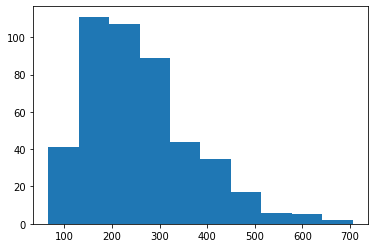

In [22]:
plt.hist(totdistr)

In [ ]:
totdistr = []
for i in range(0, 457):
    best , flattened, prepared_pgraphs, mask, sents, posids, pred, posadd, flnodes, bp, beplist, besclist, nolen = test_graph_verb(i, base, weightaddprob)
    totdistr.append(nolen+posadd)

In [7]:
pcnt = 0
IND = 46
best , flattened, prepared_pgraphs, mask, sents, posids, pred, posadd, flnodes, bp, beplist, besclist, nolen = test_graph_verb(IND, base, weightaddprob)
print(len(flattened))
print(len(prepared_pgraphs[0]))
print(nolen)

original nodes -  429
final detokd -  438
maxend , 16
suboptimal,  ['</s>', 'A', 'prudent', 'fiscal', 'policy', 'approach', ',', 'introduce', 's', 'the', 'space', 'for', 'lower', 'social', 'contribution', '.']
SRC - Une démarche fiscale prudente mise en place alors que l'économie reprenait et que les taux d'intérêts baissaient créa l'espace nécessaire à une fiscalité réduite et à la baisse des cotisations sociales. 
PRED - </s> A prudent fiscal policy approach, introduces the space for lower social contribution.
REF - A prudent fiscal stance, pursued while the economy recovered and interest rates fell, created room for big cuts in taxes and social contributions. 
285
236
236


In [9]:
max([len(bp) for bp in beplist])

29

In [29]:
posadd

49

In [16]:
nset = set()
for f in flnodes:
    nset.add(str(f.token_idx)+str(f.pos))
len(nset)

427

In [25]:
len(beplist[445])

45

In [11]:
s = ""
for p in prepared_pgraphs[0]:
    s+=" "+ xlm_tok.decode(p['token_idx']) 
s

TypeError: 'DLReverseNode' object is not subscriptable

In [ ]:
flattened[34:]

In [ ]:
import math

In [ ]:
len(flnodes)

In [ ]:
# sanity checks - 
# - are the scores actually storing probabilities? YES
# - flnodes has different length than flattened? nevermind that's just because of weirdness from earlier
[math.log(fl.prob) for fl in flnodes]

In [ ]:
mask[32:, 32:][10]

In [ ]:
prepared_pgraphs

In [ ]:
torch.sum(mask[32])

In [ ]:
def vis_context(ind):
    row = mask[ind]
    cont = " " 
    indtmp = 0
    for c in row:
        if c>0:
            cont = cont + " " + xlm_tok.decode(sents[0][indtmp])
        indtmp+=1
    cont += " : " +xlm_tok.decode(sents[0][ind])
    return cont[160:]

In [ ]:
mask[32:350, 32:350][60]

In [ ]:
mlen = min(512-(posadd+1), len(flnodes))
maxpos = mask_prep_canv(flnodes)
back_adjac = adj_mat(flnodes, mlen)

In [ ]:
flnodes[5].prevs[0].token_str

In [ ]:
tot = back_adjac
tmp = back_adjac
# keep on going until all nodes hit the back
while torch.sum((tot[:, 0]>0))<(mlen-1):
    tmp = torch.mm(back_adjac, tmp)
    tot += tmp
tot = tot+ torch.eye(mlen)
return (tot>0).int()

In [ ]:
# best , flattened, prepared_pgraphs, mask, sents, posids, pred

decs = [xlm_tok.decode(d['token_idx']) for d in flattened]
for d in decs:
    print(d)

In [ ]:
len(retvals)

In [ ]:
len(ppres)

In [ ]:
frpreds = get_all_preds("frtest_reversed/")

In [ ]:
depreds = get_all_preds("detest_reversed/")

In [ ]:
basedir = "frtest_reversed/"
l = len(os.listdir(basedir))
res = []

In [ ]:
for i in range(l):
    i, r, p = test_graph_ind(i, basedir)
    if i==None:
        continue
    res.append({
        'src':i,
        'hyp':p,
        'ref':r
    })
    print(i)
resdf = pd.DataFrame(res)
frpreds = resdf
#resdf.to_csv("frenchlatpreds")

In [ ]:
del model
model = er.XLMCometEmbeds(drop_rate=0.1)
model.load_state_dict(torch.load("./torchsaved/germanlat0.pt"))
model.eval()

In [ ]:
basedir = "detest_reversed/"
l = len(os.listdir(basedir))
res = []
for i in range(l):
    i, r, p = test_graph_ind(i, basedir)
    res.append({
        'src':i,
        'hyp':p,
        'ref':r
    })
    print(i)
resdf = pd.DataFrame(res)
depreds = resdf.to_csv("germanlatpreds")

In [ ]:
resdf

In [ ]:
frpreds = pd.read_csv("frenchlatpreds")

In [ ]:
depreds.loc[0]['hyp']

In [ ]:
def get_act_hyps(hyplist, cutoff):
    res = []
    for h in hyplist:
        cind = h[3:].index(cutoff)+len(cutoff)+3
        res.append(h[cind:])
    return res

In [ ]:
frpreds['ahyp'] = get_act_hyps(frpreds['hyp'], "<s>")

In [ ]:
frpreds

In [ ]:
def get_comet_scores(hyps, srcs, refs):
    cometqe_input = [{"src": src, "mt": mt, "ref":ref} for src, mt, ref in zip(srcs, hyps, refs)]
    # sentence-level and corpus-level COMET
    outputs = comet.predict(
        cometqe_input, batch_size=32, progress_bar=True
    )
    torch.cuda.empty_cache()
    return outputs

In [ ]:
cometqe_dir = "./cometqemodel"
# can alternatively use wmt21-comet-qe-mqm
cometqe_model = "wmt20-comet-qe-da"
cometmodel = "wmt20-comet-da"
batch_size = 64
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [ ]:
from comet import download_model, load_from_checkpoint


In [ ]:
comet_path = download_model(cometmodel, "./cometmodel")
comet = load_from_checkpoint(comet_path)
comet.to(device)

In [ ]:
del model

In [ ]:
scos = get_comet_scores(frpreds['ahyp'], frpreds['src'], frpreds['ref'])

In [ ]:
frpreds['scos'] = scos[0]

In [ ]:
frpreds.to_csv("frenchlatpreds")

In [ ]:
frpreds[frpreds['scos']<0].loc[25]['ref']

In [ ]:
sum(depreds['scos'])/1077

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(frpreds['scos'])

In [ ]:
tok = fl.bert_tok

In [ ]:
graph = pickle.load(open(base+str(2), 'rb'))

In [ ]:
graph['root'].prevs

In [ ]:
# Debugging stuff out 
# override this function
# TODO will need to update if there are new changes
flattened = fl.flatten_lattice(graph)
ppinput = prepend_input(flattened, graph['input'])
flattened = ppinput[0]
covered = fl.get_cover_paths(flattened)

In [ ]:
def find_tind(ftd, val):
    finds = []
    ind = 0
    for t in ftd:
        if val in tok.decode(t['token_idx']):
            print(tok.decode(t['token_idx']))
            print(ind)
            finds.append(ind)
            
        ind+=1
    return finds

def find_byid(ftd, idval):
    i = 0
    for t in ftd:
        
        if t['id']==idval:
            print(i)
            return t
        i+=1
    return None

def track_to_end(ftd, tstart):
    cur = tstart
    while len(cur['nexts'])>0:
        print(tok.decode(cur['token_idx']))
        #print(len(cur['nexts']))
        itmp = -1
        while find_byid(ftd, cur['nexts'][itmp]) is None:
            itmp-=1
        cur = find_byid(ftd, cur['nexts'][itmp])
find_tind(flattened, "Another")

In [ ]:
flattened[351]

In [ ]:
track_to_end(flattened, flattened[335])

In [ ]:
find_byid(flattened, '3789 40')

In [ ]:
tok.decode(2)

In [ ]:
len(flattened)
# We want - Another variable is the degree to which other developed countries’ monetary policies will ease.
# We got - The other variable is the extent to which other developed economies’ monetary policies will become more liberal.

In [ ]:
posadd = ppinput[1]
mask = causal_mask(flattened, posadd)
sents, posids = create_inputs([flattened])
with torch.no_grad():
    pred = model(sents, posids, mask.unsqueeze(0).to(device))
fls = [flattened]
prepared_pgraphs = prepare_pgraphs(fls, pred[0])
bestpath = dp_pgraph(prepared_pgraphs[0])
best = xlm_tok.decode(bestpath)
print("SRC - "+graph['input'])
print("PRED - "+best)
print("REF - "+graph['ref'])
# return best, covered, flattened, prepared_pgraphs, mask, sents, posids, pred

In [ ]:
tok.decode([t['token_idx'] for t in prepared_pgraphs[0]])

In [ ]:
graph['root'].nextlist[0].nextlist[1].token_str

In [ ]:
def vis_node(node):
    for no in node.nextlist:
        print(no.token_str)

In [ ]:
# We want - Another variable is the degree to which other developed countries’ monetary policies will ease.
vis_node(n)

In [ ]:
n.prob

In [ ]:
base = "frtest_reversed/"


In [ ]:
from new_flatten_lattice import get_dictlist
import os

In [ ]:
flatlat = get_dictlist(base+str(5))

In [ ]:
overcnt

In [ ]:
overcnt = 0
for ind in range(450):
    fl = get_dictlist(base+str(ind))

    if len(fl)>450:
        overcnt+=1
overcnt


In [ ]:
class DLReverseNode():
    def _get_dictlist_(self, oldnode):
        self.uid = oldnode.uid
        self.prob = oldnode.prob
        self.token_idx = oldnode.token_idx
        self.token_str = oldnode.token_str
        self.nextlist = oldnode.nextlist
        self.next_scores = oldnode.next_scores
        self.next_ids = oldnode.next_ids
        self.prevs = []
        self.detoks = []
        self.pos = -1
        self.canvpos = 1000
        if oldnode.pos>0:
            self.prevs = oldnode.prevs
            self.pos = oldnode.pos
            self.detoks = oldnode.detoks
            self.canvpos = oldnode.canvpos
        
    def __str__(self):
        return self.token_str

In [ ]:
del dblgrph

In [ ]:
base = "frtest_reversed/"
toker = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-one-mmt")
detok = AutoTokenizer.from_pretrained("xlm-roberta-base")

In [ ]:
# TODO later on just move this to the initial graph reversal
def get_dbl_graph(grph):
    newgrph = {}
    for g in grph.keys():
        if g=="input" or g== "ref" or g== "rootid":
            continue
        tmp = DLReverseNode(grph[g])
        newgrph[g] = tmp
    for gk in newgrph.keys():
        if gk=="input" or gk== "ref" or gk== "rootid":
            continue
        # this should handle everything having a previous list
        newgrph[gk].nextlist = None
        newgrph[gk].nextlist = [newgrph[idl] for idl in newgrph[gk].next_ids]
    for gk in newgrph.keys():
        if gk=="input" or gk== "ref" or gk== "rootid":
            continue
        for n in newgrph[gk].nextlist:
            n.prevs.append(newgrph[gk])
        newgrph[gk].token_idx = [newgrph[gk].token_idx]
    # TODO do something to update scores on word graph
    return newgrph

# greedily traverse graph, run function on each node
def greedy_traverse(gr, fun, norev=True):
    queue = []
    queue.append(gr['root'])
    visited = []
    while len(queue)>0:
        cur = queue.pop()
        fun(cur, gr)
        order = np.argsort([n.prob for n in cur.nextlist])
        # highest prob gets popped off first
        for o in order:
            if cur.uid not in visited:
                queue.append(cur.nextlist[o])
        visited.append(cur.uid)
                
# make so graph has word-only nodes, check tokenization at different node boundaries
# update pointers afterwards
def combine_nodes(gr):
    dblgrph = get_dbl_graph(gr)
    #print("Doubly Linked - ", len(dblgrph.keys()))
    greedy_traverse(dblgrph, consolidate_node)
    rmlist = []
    for d in dblgrph.keys():
        if d=="input" or d== "ref" or "root" in d:
            continue
        if len(dblgrph[d].prevs)==0:
            rmlist.append(d)
    for r in rmlist:
        del dblgrph[r]
    return dblgrph

# do this on every node greedily to get flattened lattice canvas
def add_to_flat(node, grph):
    global flat
    if node.canvpos<1000:
        return
    flat.append(node)
    # get detokenization
    detok_tmp = detok(node.token_str).input_ids[1:-1]
    # update pos on first greedy hit
    if len(node.prevs)==0:
        node.pos = -1 + len(detok_tmp)
    if node.pos==-1:
        node.pos = max([n.pos for n in node.prevs])+len(detok_tmp)
    node.detoks = detok_tmp
    node.canvpos = len(flat)-2+ len(detok_tmp)
    
flat = []
def get_flat_lattice(gr):
    global flat
    flat = []
    wordgraph = combine_nodes(gr)
    # print("Combined nodes - ", len(wordgraph))
    # clear out prevs
    for gk in wordgraph.keys():
        if gk=="input" or gk== "ref" or gk== "rootid":
            continue
        wordgraph[gk].prevs = []
    # reset prevs
    for gk in wordgraph.keys():
        if gk=="input" or gk== "ref" or gk== "rootid":
            continue
        for n in wordgraph[gk].nextlist:
            n.prevs.append(wordgraph[gk])
    greedy_traverse(wordgraph, add_to_flat)
    # print("Greedy traversal - ", len(flat))
    cp = [f for f in flat]
    return cp

def split_dl_node(node):
    if len(node.detoks)==1:
        return [node]
    res = []
    # update previous of nodes
    for i in range(len(node.detoks)):
        n = node.detoks[i]
        # make a copy of our base node
        tmp = DLReverseNode(node)
        if i>0:
            tmp.prevs = [res[-1]]
            # only have probability on 1
            tmp.prob = 1
        tmp.uid = tmp.uid+str(i)
        tmp.pos = tmp.pos - (len(node.detoks)-i-1)
        tmp.canvpos = tmp.canvpos - (len(node.detoks)-i-1)
        tmp.token_idx = n
        tmp.token_str = detok.decode(n)
        res.append(tmp)
    # update next connection of nodes
    for i in range(len(res)-1):
        if i<(len(node.detoks)-1):
            res[i].next_ids = [res[i+1].uid]
            res[i].nexts = [res[i+1]]
    return res
        
def tokenize_flat_lattice(gr):
    # get rid of first token, usually en_XX for french
    print("original nodes - ", len(gr.keys()))
    tmplist = gr['root'].nextlist[0].nextlist
    tmpids = gr['root'].nextlist[0].next_ids
    gr['root'].nextlist = tmplist
    gr['root'].next_ids = tmpids
    flatlat = get_flat_lattice(gr)
    res = []
    #print("flatlat - ", len(flatlat))

    for f in flatlat:
        res.extend(split_dl_node(f))
    print("final detokd - ", len(res))
    return res
    # we need to go through and convert this into lattices compatible 
    # with the format further into the pipeline, need to tokenize again with BERT
    
# disconnect / throw away node
def throw_garbage(node, grph, lprevs=False):
    assert len(node.prevs)==0 or len(node.nextlist)==0
    for pre in node.prevs:
        if node in pre.nextlist:
            pre.nextlist.remove(node)
        if node.uid in pre.next_ids:
            pre.next_ids.remove(node.uid)

    if lprevs:
        for n in node.nextlist:
            n.prevs.remove(node)
    if node.uid not in grph.keys():
        #print("w")
        ""
    else:
        del grph[node.uid]
        
# assume that previous nodes are consolidated, 
def consolidate_node(node, grph):
    if node.uid not in grph.keys():
        return
    goneprevs = []
    # check relationship with all previous nodes
    for prev in node.prevs:
        # it's a word boundary, no changes
        comb = toker.decode(prev.token_idx+node.token_idx)
        if " " in comb or "</s>" in comb:
            continue
        else:
            # need to make new node, add necessary stuff
            #print(comb)
            tmp = DLReverseNode(node)
            tmp.token_str = comb
            tmp.token_idx = prev.token_idx+node.token_idx
            tmp.prob = prev.prob*node.prob
            tmp.prevs = []
            tmp.prevs.extend(prev.prevs)
            tmp.uid = prev.uid+node.uid
            
            # connect previous nodes
            for pre in tmp.prevs:
                pre.nextlist.append(tmp)
                pre.next_ids.append(tmp.uid)
            
            grph[tmp.uid] = tmp
            # cut off from others where necessary
            goneprevs.append(prev)
            
            if node in prev.nextlist:
                prev.nextlist.remove(node)
                if node.uid in prev.next_ids:
                    prev.next_ids.remove(node.uid)
            
            for t in tmp.nextlist:
                t.prevs.append(tmp)
            # prev now garbage, delete it
            if len(prev.nextlist)==0:
                throw_garbage(prev, grph, True)
            """
            if comb=="China’":
                print("nexts after", len(tmp.nextlist))
                print(tmp.uid)
                print(tmp.nextlist[0].prevs[1].uid)
            """
            
    for g in goneprevs:
        node.prevs.remove(g)
    if len(node.prevs)==0:
        throw_garbage(node, grph)
        

def get_dictlist(grphinp):
    fllat = tokenize_flat_lattice(grphinp)
    tdicts = []
    for f in fllat:
        tdicts.append({
            'token_idx': f.token_idx,
            'pos': f.pos, 
            'id': f.uid,
            'nexts': [fn.uid for fn in f.nextlist], 
            'score': math.log(f.prob)
        })

In [ ]:
import math

In [ ]:
graph = pickle.load(open(base+str(0), 'rb'))
flatlat = get_dictlist(graph)

In [ ]:
for i in range(75):
    graph = pickle.load(open(base+str(i), 'rb'))
    flatlat = tokenize_flat_lattice(graph)
    print(len(flatlat))
    #combnodes = combine_nodes(graph)

In [ ]:
def check_duptok(flat, ind):
    check = flat[ind]
    prestrs = set([fla.uid for fla in check.prevs])
    nestrs = set([ns.token_str for ns in check.nextlist])
    others = flat[:ind]
    if ind<len(flat)-1:
        others.extend(flat[ind+1:])
    res = []
    for f in others:
        if check.token_str==f.token_str:
            
            if prestrs==set([fla.uid for fla in f.prevs]):
                res.append(f.token_str)
    return res
"""
TODO look into issue of duplicates

bigre = []
for i in range(len(flatlat)-1):
    print(check_duptok(flatlat, i))
"""


In [ ]:
combnodes['root'].nextlist

In [ ]:
toker.decode([9098, 26, 7])

In [ ]:
graph['root'].nextlist[0].nextlist[0].nextlist[0].nextlist[0].nextlist[0].nextlist[0].nextlist[0].token_idx

In [ ]:
for gk in combnodes.keys():
    if len(combnodes[gk].nextlist)==0:
        print(combnodes[gk].token_str)

In [ ]:
len(flatlat)

In [ ]:
[f.token_str+" "+str(f.pos) for f in flatlat]

In [ ]:
gra = combine_nodes(graph)
weirds = []
print(len(gra.keys()))
for gk in gra.keys():
    if gk=="input" or gk== "ref" or gk== "rootid":
        continue
    print(gra[gk])
    if len(gra[gk].nextlist)==0:
        
        weirds.append(gra[gk])

In [ ]:
# We want - Another variable is the degree to which other developed countries’ monetary policies will ease.
node = gra['root'].nextlist[0].nextlist[0].nextlist[0].nextlist[0].nextlist[0].nextlist[2].nextlist[0].nextlist[0].nextlist[1].nextlist[0].nextlist[1].nextlist[0].nextlist[0].nextlist[0].nextlist[2]
for n in node.nextlist:
    print(n)

In [ ]:
toker = AutoTokenizer.from_pretrained("facebook/mbart-large-50-many-to-one-mmt")

In [ ]:
doublegraph = get_dbl_graph(graph)

In [ ]:
doublegraph['root'].nextlist

In [ ]:
combine_nodes(graph)

In [ ]:
# TODO delete if not useful
def update_node_prevs(dblgraph, node):
    # check if already in existing nodes
    if node.uid in dblgraph.keys():
        return
    # TODO make sure to use the right kind of node
    cur = node
    while len(cur.nextlist)==1:
        if cur.nextlist[0].uid in dblgraph.keys():
            tmp = dblgraph[cur.nextlist[0].uid]
        else:
            tmp = DLReverseNode(cur.nextlist[0])
        tmp.prevs.append(cur)
        # don't keep going if we've already done this node at some point
        if cur.nextlist[0].uid in dblgraph.keys():
            return 
        dblgraph[cur.nextlist[0].uid] = tmp
        cur = tmp
    # hit the end of segment, multiple choices now
    if len(cur.nextlist)>1:
        for n in cur.nextlist:
            if n.uid in dblgraph.keys():
                nnode = dblgraph[n.uid]
            else:
                nnode = DLReverseNode(n)
            nnode.prevs.append(cur)
            dblgraph[n.uid] = nnode
            update_node_prevs(dblgraph, n)
    

In [ ]:
graph['root'].nextlist[0].prevs[1].token_str

In [ ]:
# flatten out lattice 
def flatten_lattice(graph):
    tokdicts = []
    visited = []
    prev_contig = []
    greedy_flatten(tokdicts, visited, graph['root'], 0, prev_contig, set())
    #greedy_flat_old(tokdicts, visited, graph['root'], 0)
    return tokdicts

max_splits = -1
splits_hit = 0
# flattens graph by position, ignores </s> and en_XX tokens for greater BERT compatibility
# TODO set up to use mbart tokenization
def greedy_flatten(tdicts, visited, node, pos, prev_cont, added_ids, branch_start=None):
    global splits_hit
    if node.uid in visited:
        return
    if node.token_idx==2 or node.token_idx==250004:
        npos = pos
    else:
        node.pos = pos
        
        visited.append(node.uid)
        npos = pos+1
        s = node.token_str
        prev_cont.append(node)
    
    olen = len(tdicts)
    # we're hitting a branch or an ending, update to bert tokenization and add to visited
    # should be ok to do this since branching / merging only happens at word boundaries (presumably)
    branched = (len(node.next_scores)>1)
    end = (len(node.next_scores)==0)
    merge = end==False and node.nextlist[0].uid in visited
    if branched or merge or end:
        if len(prev_cont)>0:
            errorflag = False
            
            prev_update = []
            for p in prev_cont:
                if p.uid in added_ids:
                    continue
                else:
                    prev_update.append(p)
                    added_ids.add(p.uid)
            
            if len(prev_update)>0:
                toktmp = get_toklist(prev_update)
                for i in range(1, len(prev_update)):
                    if prev_update[-(i+1)].pos>=prev_update[-i].pos:
                        errorflag = True
                        break
                decstr = mbart_tok.decode(toktmp)
                if errorflag:
                    #print(decstr)
                    #print([p.pos for p in prev_update])
                    ""
                bert_toks = bert_tok(decstr).input_ids
                curpos = prev_update[0].pos
                # TODO add logic that tracks scores / next nodes
                otdlen = len(tdicts)
                for bind in range(0, len(bert_toks)):
                    b = bert_toks[bind]
                    # change to 101, 102 for bert, change to 0, 2 for xlm
                    if b==0 or b==2:
                        continue
                    nid = str(b)+" "+str(curpos)
                    # if we're at the start, add this node to next of branch node
                    if len(tdicts)==otdlen and branch_start is not None:
                        branch_start['nexts'].append(nid)

                    if bind<len(bert_toks)-1:
                        tdicts.append({
                            'token_idx':b,
                            'pos':curpos, 
                            'id': nid,
                            'nexts': [str(bert_toks[bind+1])+" "+str(curpos+1)], 
                            'score': 0
                        })
                    else:
                        tdicts.append({
                            'token_idx':b,
                            'pos':curpos, 
                            'id': str(b)+" "+str(pos),
                            'nexts': [], 
                            'score': 0
                        })
                    curpos+=1
                if merge or end:
                    splits_hit+=1
            
    if len(tdicts)>olen:
        del prev_cont
        prev_cont = []
        
    # end things early if we want to limit paths
    if max_splits>=0 and splits_hit>=max_splits:
        return 
    
    scosort = list(np.argsort(node.next_scores))
    if branched and len(tdicts)>0:
        branch_start=tdicts[-1]
    # TODO check which direction we need to go from argsort
    for i in range(0, len(scosort)):
        greedy_flatten(tdicts, visited, node.nextlist[scosort[i]], npos, prev_cont, added_ids, branch_start)

In [ ]:
# topological sort the graphs, make sure that nodes that are next always come next in the list
def topo_sort_nodes(pgraph):
    cp = [p for p in pgraph]
    tmpgraph = {}
    for c in cp:
        tmpgraph[c.uid]=c
    res = []
    visited = []
    # reverse ordering
    topo_recurse(cp[0].uid, res, [], tmpgraph)
    # don't reverse anymore
    # res.reverse()
    return res
        
def topo_recurse(curid, toplist, visited, graph):
    if curid in visited:
        return 
    # for stuff in truncated part of graph TODO
    if curid not in graph.keys():
        return
    node = graph[curid]
    visited.append(curid)
    for nid in [n.uid for n in node.nextlist]:
        topo_recurse(nid, toplist, visited, graph)
    # once done, add to the beginnings
    toplist.insert(0, node)

    # take in list of truncnodes, sort for dynamic programming
def prepare_nodes(truncnodes, scores, padd):
    ind = 0
    for p in range(len(truncnodes)):
        # get rid of this later if we decide to have multiple canvi
        assert len(truncnodes[p])<=512
        for i in range(min(len(truncnodes[p]),512)):
            # get score after offset (we only get for decoded stuff)
            # TODO do some kind of assert
            truncnodes[p][i].score = scores[p][i+padd]
    
    result = []
    for trunc in truncnodes:
        result.append(topo_sort_nodes(trunc))
        
    for trunc in result:
        dpos = 0
        for node in trunc:
            node.dppos = dpos
            dpos+=1
            
    return result

MINPROP = 0.7
def dynamic_path(prepnodes, sco_funct, posapp):
    
    bplist = [None]*len(prepnodes)
    bscolist = [-10000]*len(prepnodes)
    endings = []
    # go through topologically sorted list of nodes, update best path for each
    for prep in prepnodes:
        if bplist[prep.dppos]==None:
            bplist[prep.dppos] = []
        if len(prep.prevs)>0:
            mval = -10000
            mprev = None
            for p in prep.prevs:
                if p.dppos>=0 and bscolist[p.dppos]>mval:
                    mval = bscolist[p.dppos]
                    mprev = p
            if mprev is not None:
                # use from previous
                bplist[prep.dppos].extend(bplist[mprev.dppos])
                bscolist[prep.dppos] = bscolist[mprev.dppos] + prep.score
                #print(bscolist[prep.dppos])
        # TODO look into endings that are happening due to excessive trunction
        if len(prep.nextlist)==0:
            endings.append(prep.dppos)
        if bscolist[prep.dppos]==-10000:
            bscolist[prep.dppos]= prep.score
        bplist[prep.dppos].append(prep)
        #bscolist[prep.dppos] += prep.score
    
    print(endings)
    print([float(bscolist[e]) for e in endings])
    bestpath = []
    bestsco = -10000
    for e in endings:
        # make sure we hit minimum length proportional to input
        if len(bplist[e])>(MINPROP)*posapp:
            if bscolist[e]>bestsco:
                bestsco = bscolist[e]
                bestpath = bplist[e]
    return bestpath, bplist, bscolist
    